In [1]:
%matplotlib notebook
from pymba import Vimba, VimbaException
import time
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime
from pathlib import Path

%matplotlib notebook

import all the features

In [2]:
dtype = None
with Vimba() as vimba:
        camera = vimba.camera('DEV_000F315C8C83')
        camera.open()
        for feature_name in camera.feature_names():
            feature = camera.feature(feature_name)

            try:
                value = feature.value
                range_ = feature.range
                dtype = type(value)

                # alternatively the feature value can be read as an object attribute
                # value = getattr(camera, feature_name)
                # or
                # value = camera.someFeatureName

            except VimbaException as e:
                value = e
                range_ = None

            print('\n\t'.join(
                str(x) for x in (
                    feature_name,
                    'value: {}'.format(value),
                    'range: {}'.format(range_),
                    'type:{}'.format(dtype))
                if x is not None))
            
        camera.close()

AcquisitionAbort
	value: Cannot get or set the value of a command feature type, call the command instead.
	range: None
	type:None
AcquisitionFrameCount
	value: 1
	range: (1, 65535)
	type:<class 'int'>
AcquisitionFrameRateAbs
	value: 309.98140111593307
	range: (0.0015129371986062677, 2958.579881656805)
	type:<class 'float'>
AcquisitionFrameRateLimit
	value: 385.50501156515037
	range: (0.0015129371986062677, 2958.579881656805)
	type:<class 'float'>
AcquisitionMode
	value: SingleFrame
	range: ['Continuous', 'SingleFrame', 'MultiFrame', 'Recorder']
	type:<class 'str'>
AcquisitionStart
	value: Cannot get or set the value of a command feature type, call the command instead.
	range: None
	type:<class 'str'>
AcquisitionStop
	value: Cannot get or set the value of a command feature type, call the command instead.
	range: None
	type:<class 'str'>
BandwidthControlMode
	value: StreamBytesPerSecond
	range: ['StreamBytesPerSecond', 'SCPD', 'Both']
	type:<class 'str'>
BlackLevel
	value: 4.0
	range: (0

SyncOutLevels
	value: 0
	range: (0, 4294967295)
	type:<class 'int'>
SyncOutPolarity
	value: Normal
	range: ['Normal', 'Invert']
	type:<class 'str'>
SyncOutSelector
	value: SyncOut1
	range: ['SyncOut1', 'SyncOut2', 'SyncOut3', 'SyncOut4']
	type:<class 'str'>
SyncOutSource
	value: Exposing
	range: ['GPO', 'AcquisitionTriggerReady', 'FrameTriggerReady', 'Exposing', 'FrameReadout', 'Imaging', 'Acquiring', 'LineIn1', 'LineIn2', 'Strobe1']
	type:<class 'str'>
ThresholdPWL1
	value: 63
	range: (0, 63)
	type:<class 'int'>
ThresholdPWL2
	value: 63
	range: (0, 63)
	type:<class 'int'>
TriggerActivation
	value: RisingEdge
	range: ['RisingEdge', 'FallingEdge', 'AnyEdge', 'LevelHigh', 'LevelLow']
	type:<class 'str'>
TriggerDelayAbs
	value: 0.0
	range: (0.0, 330482984.0)
	type:<class 'float'>
TriggerMode
	value: On
	range: ['Off', 'On']
	type:<class 'str'>
TriggerOverlap
	value: Off
	range: ['Off', 'ReadOut', 'PreviousFrame']
	type:<class 'str'>
TriggerSelector
	value: FrameStart
	range: ['FrameStart'

extend the streaming to also save the reading

<IPython.core.display.Javascript object>


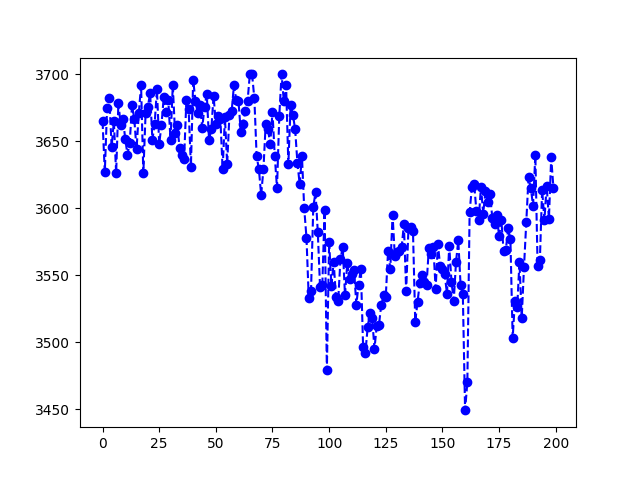

<IPython.core.display.Javascript object>


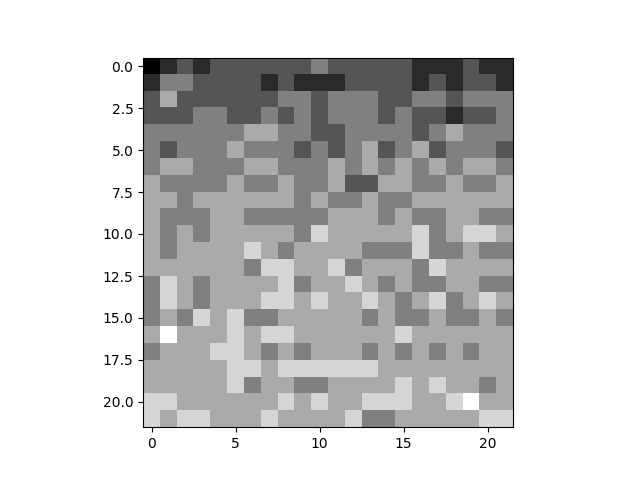

VimbaException: Timeout during wait.

In [3]:
drop=0
total=0
array=[]
ROI_sum=0
time_series=[]

left=325 #min value 0
right=425 #max value 644 for Mako
up=150 #min value 0
down=250 #max value 484 for Mako

# time between images in s
twait = 0.5

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.ion()
fig1.show()
fig1.canvas.draw()

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

def cp(f,tag):
    image = f.buffer_data_numpy()
    #image = image[up:down,left:right]
    ROI_sum=np.sum(image)
    array.append(ROI_sum)
    #time_series.append((tag,ROI_sum))
    if len(array)>200:
        array.pop(0)
    ax1.clear()
    ax2.clear()
    ax1.plot(array,'o--b')
    ax2.imshow(image,cmap = 'gray')
    fig1.show()
    fig1.canvas.draw()
    fig2.show()
    fig2.canvas.draw()
    #timestamp = time.time()
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    data = [timestamp, ROI_sum]
    
    full_path = Path(Path.home().as_posix()+'/Dropbox (CoQuMa)/LabNotes/NaKa/'+timestamp[:7]+'/'+timestamp[:10]+'/data')
    try :
        full_path.mkdir(parents=True, exist_ok=True)
    except FileExistsError :
        print('already exists!')
        full_path = Path(Path.cwd().as_posix()+'/data')
                        
    with open(str(full_path)+'\\mako_'+timestamp[:10]+'.csv', 'a', newline='', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(data)
    
if __name__ == '__main__':

    with Vimba() as vimba:
        camera = vimba.camera('DEV_000F315C8C83')##   DEV_000F315C8C83      DEV_000F315C57F9      DEV_000F315C1307
        camera.open()
        camera.arm('SingleFrame')
        
        timeout = 200000   # [seconds]
        timeout_start = time.time()
  
        while time.time() < timeout_start + timeout:  # Uncomment this to capture frames for a specific time
        #for i in range(200): # Uncomment this to capture a single frame, more than once if desired
            total+=1
            try:
                frame = camera.acquire_frame(100)
                tag=time.time()-timeout_start
                cp(frame,tag)
                time.sleep(twait)
            except VimbaException as e:
                # rearm camera upon frame timeout
                if e.error_code == VimbaException.ERR_TIMEOUT:
                    drop+=1
                    #print(e)
                    camera.disarm()
                    camera.arm('SingleFrame')
                else:
                    raise

        camera.disarm()
        camera.close()

print(drop,'Frames dropped out of',total,'due to timeout')

In [ ]:
import pyrpl
from moku.instruments import ArbitraryWaveformGenerator, Oscilloscope

In [ ]:
p = pyrpl.Pyrpl(hostname="10.0.2.111", config="111.yml"); r = p.rp

In [ ]:
# shortcut to save data
def save_data(data, timestamp, device):
    full_path = Path(Path.home().as_posix()+'/Dropbox (CoQuMa)/LabNotes/NaKa/'+timestamp[:7]+'/'+timestamp[:10]+'/data')
    try :
        full_path.mkdir(parents=True, exist_ok=True)
    except FileExistsError :
        print('already exists!')
        full_path = Path(Path.cwd().as_posix()+'/data')
                        
    with open(str(full_path)+'\\' + device + '_'+timestamp[:10]+'.csv', 'a', newline='', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(data)

In [ ]:
# just keep track of the lock...
while True:
    now = datetime.datetime.now()
    timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    i = ArbitraryWaveformGenerator('10.0.2.110', force_connect=True)
    
    data = [ timestamp, np.round(r.scope.voltage_in1,3), np.round(r.pid0.setpoint,3), np.round(i.read_power_supply(1)['set_voltage'],3) ]
    
    save_data(data, timestamp, 'lock')
    print(data, end='\r')
    
    if -1 >= r.scope.voltage_in1 or 1 <= r.scope.voltage_in1 : print('Out of lock!')
        
    i.relinquish_ownership()
    
    time.sleep(5)